In [11]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [12]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [13]:
era5

<xarray.Dataset>
Dimensions:    (longitude: 289, latitude: 163, level: 23, time: 41)
Coordinates:
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * level      (level) int32 200 225 250 300 350 400 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2023-10-17 ... 2023-10-22
Data variables:
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    pv         (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    vo         (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
    w          (time, level, latitude, longitude) float32 dask.array<chunksize=(41, 23, 163, 289), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-10 11:00:59 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

# Vertical velocity 

In [7]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

In [14]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


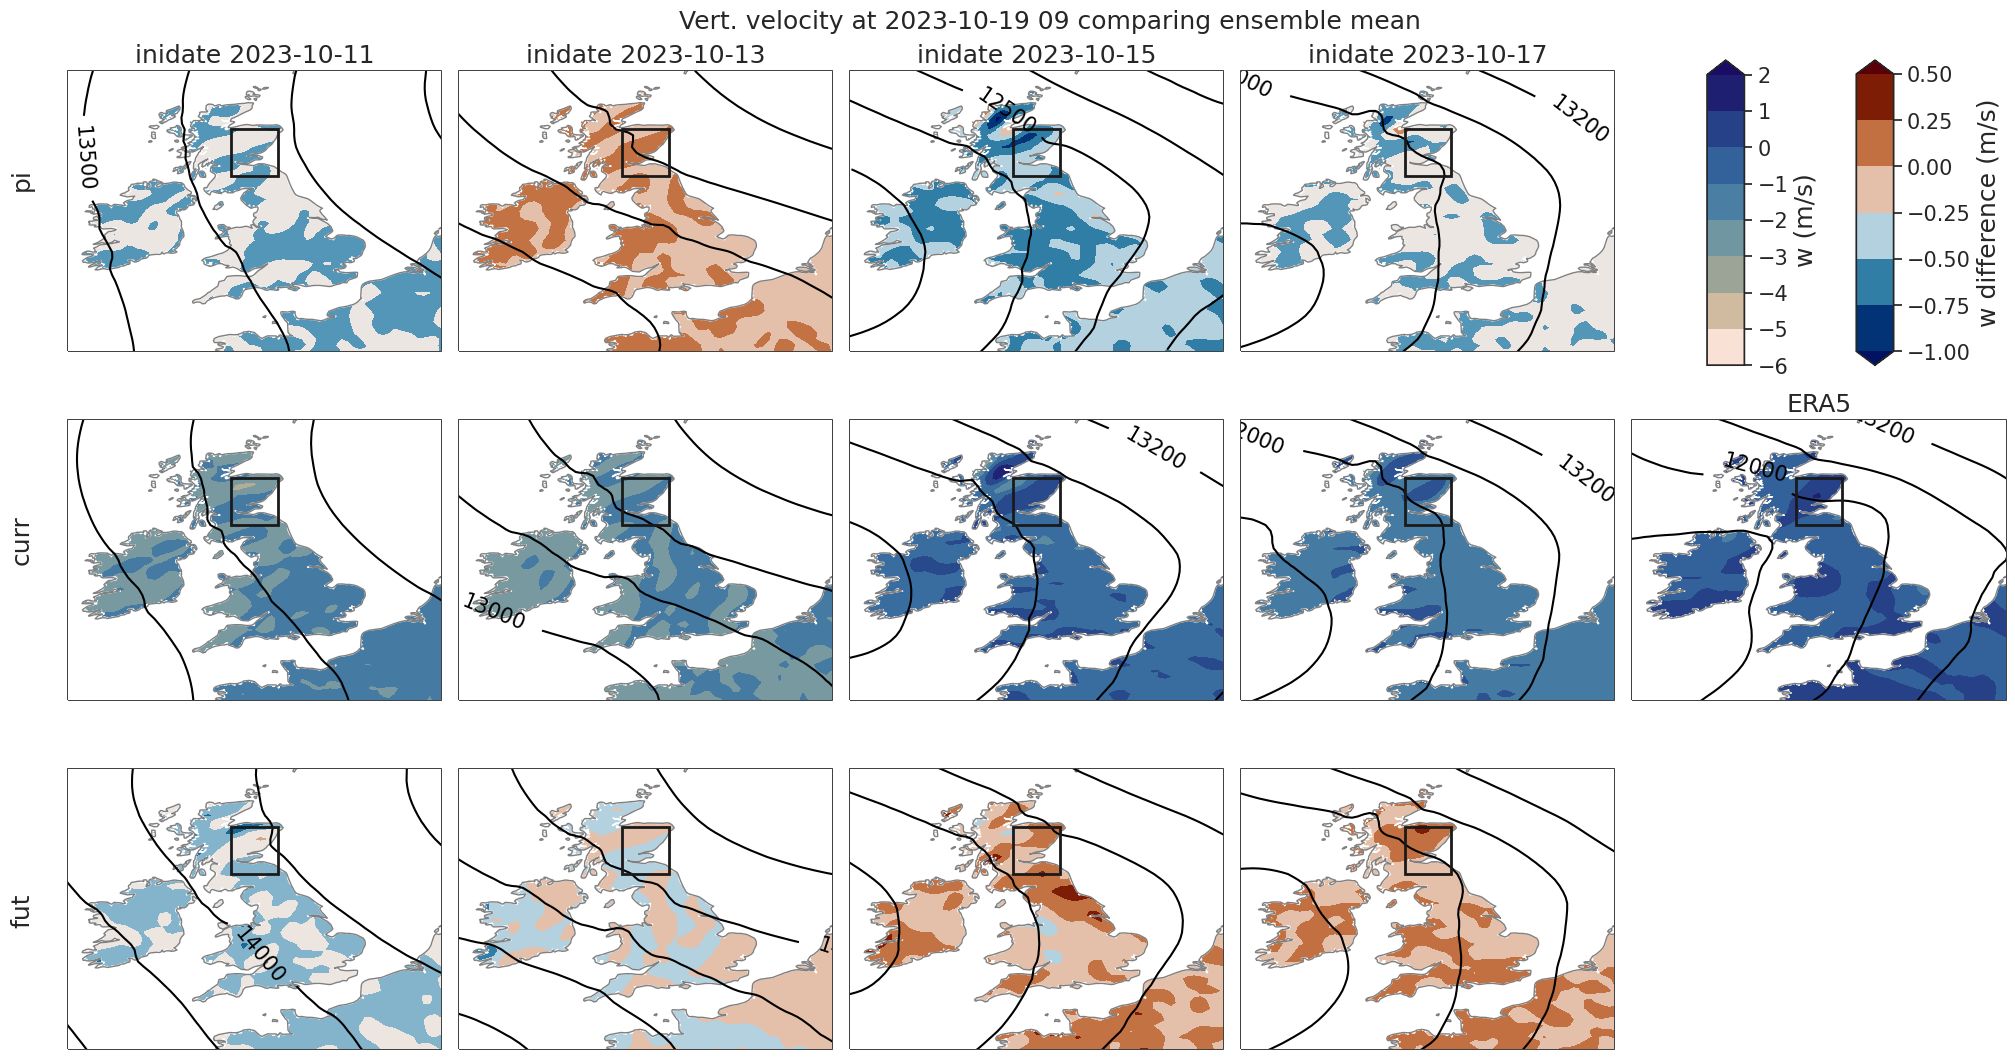

In [18]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 1030
p_min = 970

w_min = 0
w_max = 200

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            w_vals = (exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            w_vals = exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_w = np.linspace(w_min, w_max, 11)  # 17
            cf = ax.contourf(longitude, latitude,w_vals, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_w = np.linspace(-15, 15, 10)
            cf_diff = ax.contourf(longitude, latitude, w_vals, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 5)
        cs = ax.contour(longitude, latitude, p_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
w_vals = era5.w.sel(time=timestep, level=500).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_w = np.linspace(w_min, w_max, 11)  # 17
cf = ax.contourf(longitude, latitude, w_vals, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 5)
cs = ax.contour(longitude, latitude, p_vals, colors='black', # clevs_p,
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='w (m/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='w (m/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='w difference (m/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='w difference (m/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Vert. velocity at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

# plt.savefig('figures/08_w_{}.png'.format(timestep), dpi=600)
# plt.savefig('figures/08_w_{}.pdf'.format(timestep))

# Upper level winds and relative humidity

In [21]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
u_max = 30
u_min = 0

r_min = 0
r_max = 0.002

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        u_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values
        v_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            r_vals = (exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            r_vals = exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # humidity as shading
        if experiment =='curr':
            clevs_r = np.linspace(r_min, r_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, r_vals, cmap=cm.lapaz_r,
                            transform=projection, zorder = 10, extend = 'max')
        else: 
            clevs_tp = np.linspace(-15, 15, 10)
            cf_diff = ax.contourf(longitude, latitude, w_vals, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # barbs for wind
        cs = ax.barbs(longitude, latitude, u_vals, v_vals, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
w_vals = era5.w.sel(time=timestep, level=500).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# barbs for wind
clevs_tp = np.linspace(w_min, w_max, 11)  # 17
cf = ax.contourf(longitude, latitude, r_vals, cmap=cm.lapaz_r,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
cs = ax.barbs(longitude, latitude, u_vals,v_vals, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='rel. humidity ()', extend = 'max', shrink=0.8)
cbar.set_label(label='rel. humidity ()', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='rel. humidity difference ()', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='rel. humidity difference ()', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('RH and wind at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()